In [1]:
%matplotlib inline
import numpy as np
import imageio
import exifread
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns
import pandas as pd
import os
from pyspacal import mtf, utils, camera_data, first_pass
from pyspacal import DataFrameArray as dfa
import itertools
import autoreload
import h5py
import altair as alt

In [2]:
raw_fname = '/mnt/winawerlab/Projects/spatial_calibration/data/contrast_check_images/raw/capt0007.nef'
im, metadata = utils.load_img_with_metadata(raw_fname, 'no_demosaic')

In [3]:
if im.ndim == 2:
    # then it hasn't been demosaiced and we do it manuallly
    mask, kernels = mtf.create_mosaic_mask(im.shape, camera_data.BAYER_MATRICES[metadata['camera']])
    raw_demosaiced_image = mtf.demosaic_image(im, mask)
    demosaiced_image = mtf.block_avg(raw_demosaiced_image)
else:
    # then it has and we just have to rearrange the axes so that RGB is one the first one
    demosaiced_image = im.transpose((2, 0, 1))

In [4]:
demosaiced_image = demosaiced_image.mean(0)

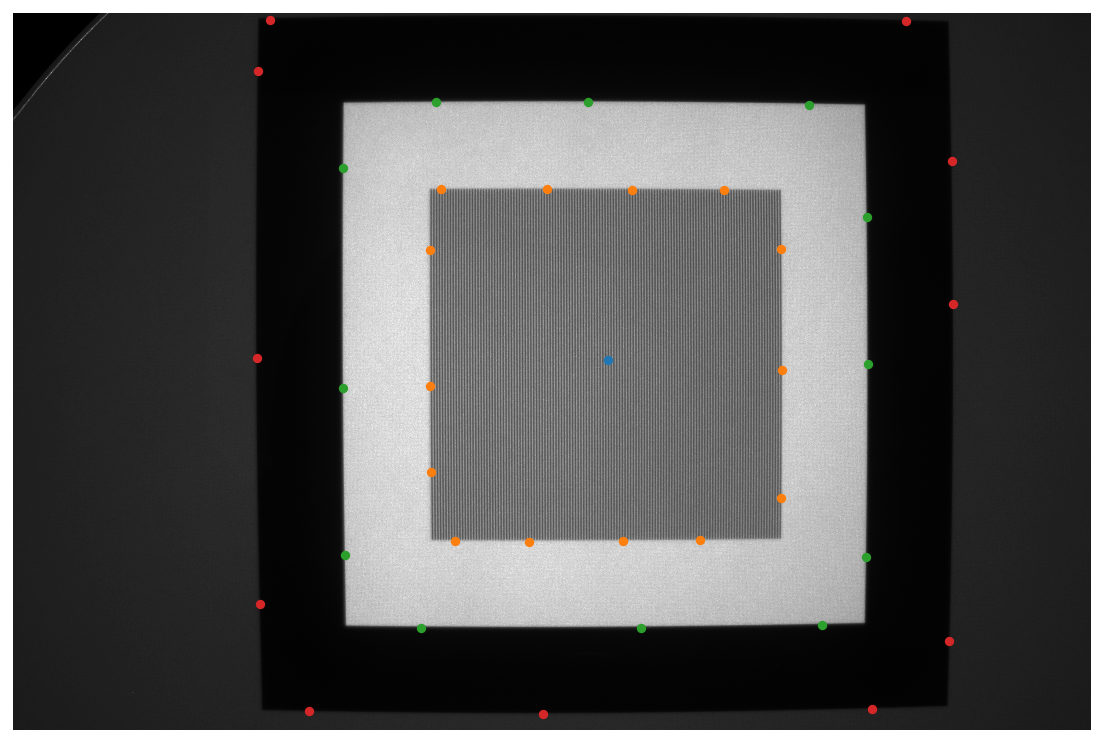

In [5]:
pts_dict = utils.load_pts_dict(metadata['filename'], demosaiced_image.shape)
fig = utils.check_pts_dict(demosaiced_image, pts_dict, .5)

Optimize for this: take all the points given along the edge and then find the r, x0, y0, $\theta$ that minimize the value of $(x-x0)^2+(y-y0)^2-\frac{r^2}{\cos\theta}$

In [6]:
x0, y0, r_grating, border_ring_width, angle = mtf.find_mask_params(**pts_dict)

Check the middle slice of the image to get a sense for how good the contrast is. This is simply approximate.

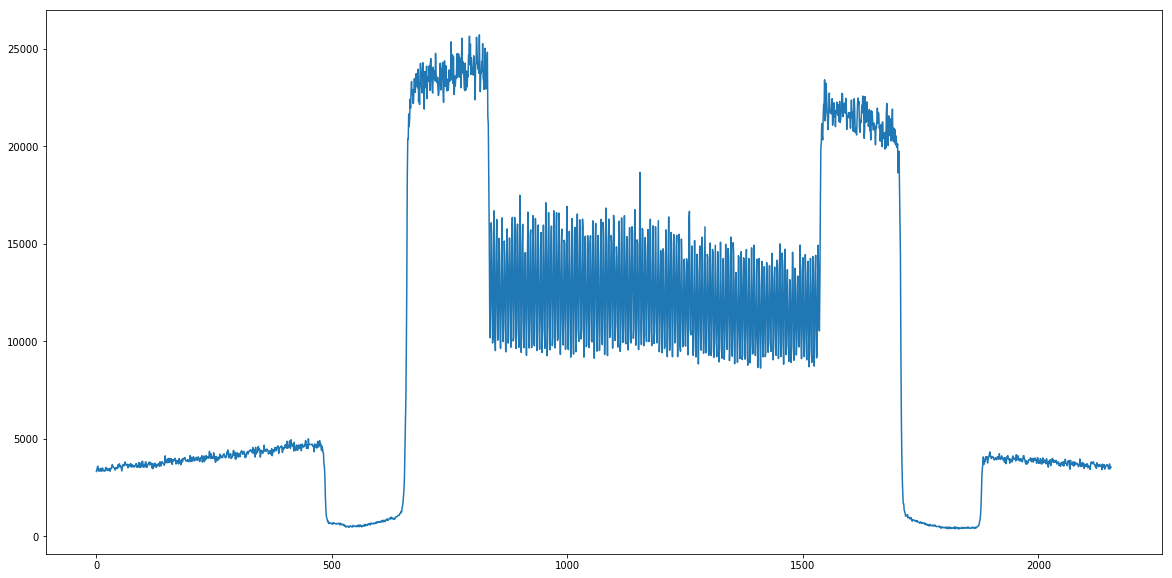

In [7]:
plt.figure(figsize=(20,10))
plt.plot(demosaiced_image[int(demosaiced_image.shape[0]-y0), :])

In [8]:
grating_mask, white_mask, black_mask = utils.create_square_masks(demosaiced_image.shape, x0, y0, r_grating, border_ring_width, angle)
grating_pts, white_pts, black_pts = utils.create_square_outlines(demosaiced_image.shape, x0, y0, r_grating, border_ring_width, angle, .5)

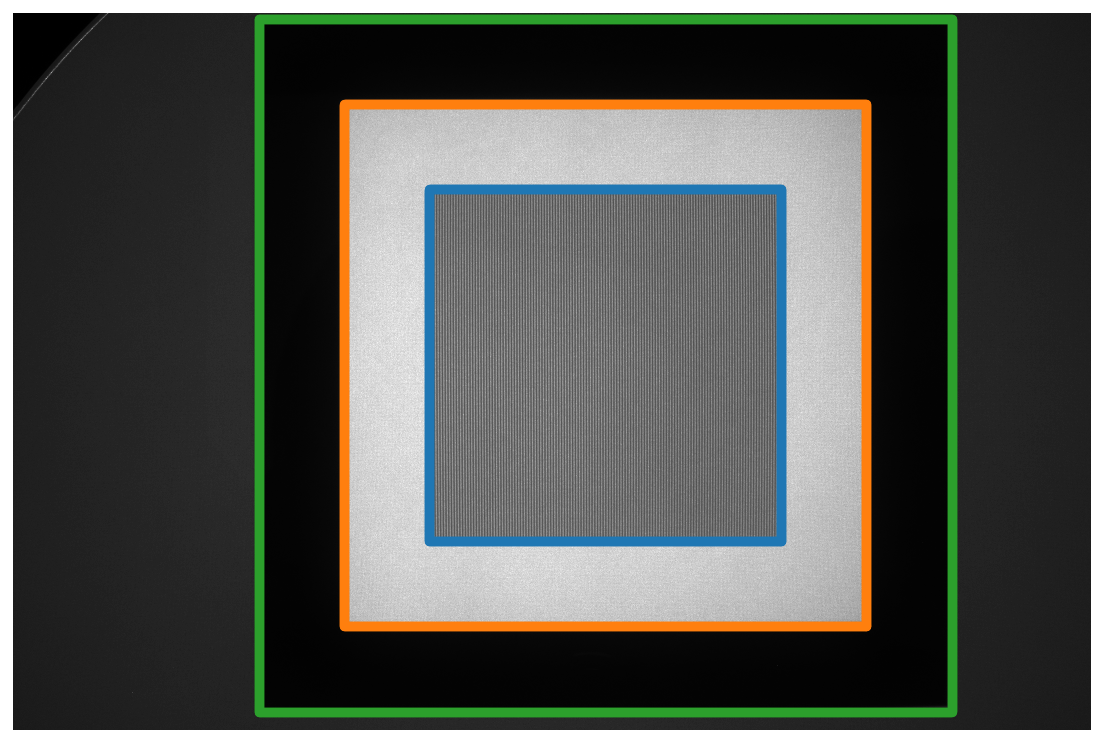

In [9]:
_=utils.check_square_outlines(demosaiced_image, grating_pts, white_pts, black_pts, .5)

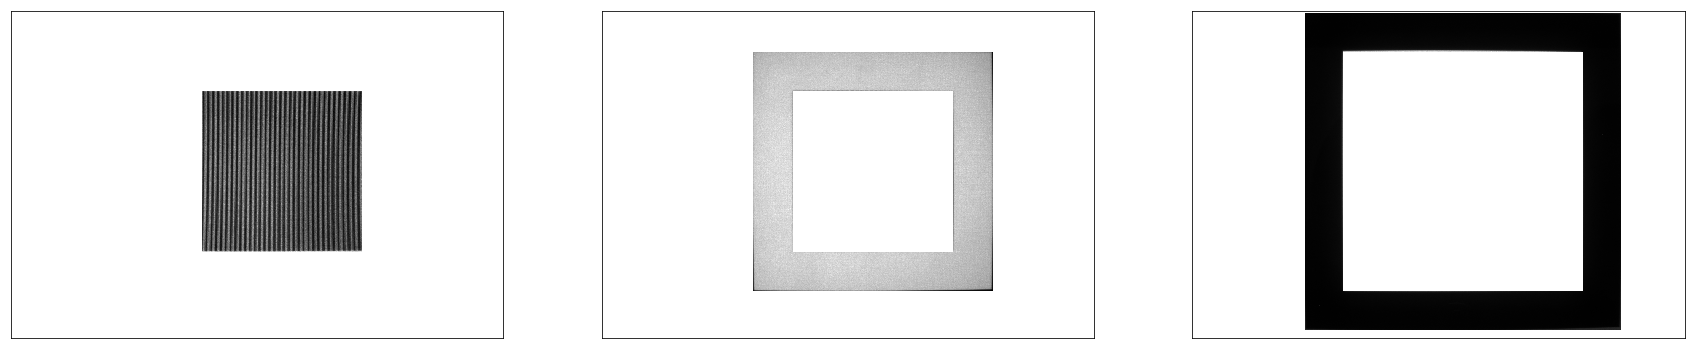

In [10]:
fig = utils.plot_masked_images(demosaiced_image, [grating_mask, white_mask, black_mask])

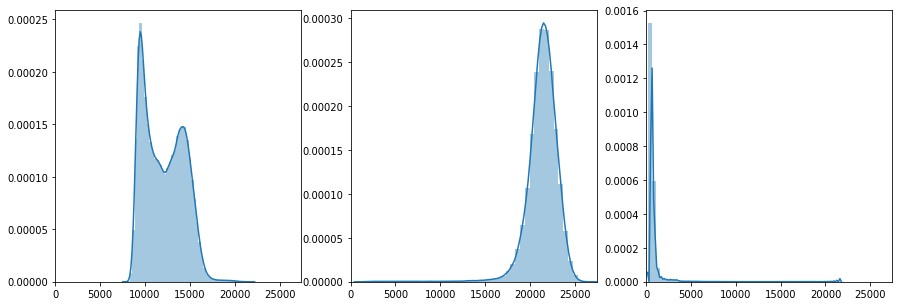

In [11]:
fig = utils.plot_masked_distributions(demosaiced_image, [grating_mask, white_mask, black_mask])

In [12]:
grating_1d = utils.extract_1d_grating(demosaiced_image, grating_mask,
                                      metadata['grating_direction'], angle)
n_cycs = int(metadata['image_content'].split(' ')[0])
# This is the size of each cycle in pixels
cyc_len_pix = len(grating_1d) / n_cycs
box_size = int(cyc_len_pix * 1)
step_size = int(cyc_len_pix * 1)


grating = demosaiced_image * grating_mask
grating[grating == 0] = np.nan
means, stddevs = first_pass.calc_mean_and_stddev(grating, box_size, step_size)

data = metadata.copy()
data.update({'means': means, 'stddevs': stddevs, 'box_size': box_size, 'step_size': step_size, 'cycle_size_pix': cyc_len_pix})
df = dfa.DataFrameArray(data)

/home/billbrod/Documents/spatial-calibration/pyspacal/utils.py:386: RuntimeWarning: Mean of empty slice
  grating_1d = np.nanmean(grating, 0)


In [13]:
df

,f_number,iso,exposure_time,focus_mode,filename,camera,preprocess_type,image_context,image_content,grating_direction,grating_size,box_size,step_size,cycle_size_pix,means,stddevs
0,16.0,200,0.25,MANUAL,capt0007,NIKON D90,no_demosaic,projector_4,128 cyc/image,vertical,256 pix,5,5,5.492188,"<2d array of size [96, 96]>","<2d array of size [96, 96]>"


# Examining results

In [2]:
df = dfa.read_csv('first_pass.csv')

In [3]:
df.head()

,level_0,index,f_number,iso,exposure_time,focus_mode,filename,camera,preprocess_type,image_context,image_content,grating_direction,grating_size,box_size,step_size,cycle_size_pix,box_size_multiple,step_size_multiple,means,stddevs
0,0,0,32.0,1600,0.05,AF-C,DSC_0239,NIKON D90,no_demosaic,projector_3,8 cyc/image,vertical,256 pix,81,81,81.375,1.0,1.0,"<2d array of size [6, 6]>","<2d array of size [6, 6]>"
1,0,0,32.0,1600,0.05,AF-C,DSC_0239,NIKON D90,dcraw_vng_demosaic,projector_3,8 cyc/image,vertical,256 pix,163,163,163.000,1.0,1.0,"<2d array of size [6, 6]>","<2d array of size [6, 6]>"
2,0,0,32.0,1600,0.05,AF-C,DSC_0239,NIKON D90,dcraw_ahd_demosaic,projector_3,8 cyc/image,vertical,256 pix,163,163,163.000,1.0,1.0,"<2d array of size [6, 6]>","<2d array of size [6, 6]>"
3,0,0,32.0,1600,0.05,AF-C,DSC_0239,NIKON D90,no_demosaic,projector_3,8 cyc/image,vertical,256 pix,81,162,81.375,1.0,2.0,"<2d array of size [3, 3]>","<2d array of size [3, 3]>"
4,0,0,32.0,1600,0.05,AF-C,DSC_0239,NIKON D90,dcraw_vng_demosaic,projector_3,8 cyc/image,vertical,256 pix,163,326,163.000,1.0,2.0,"<2d array of size [3, 3]>","<2d array of size [3, 3]>"


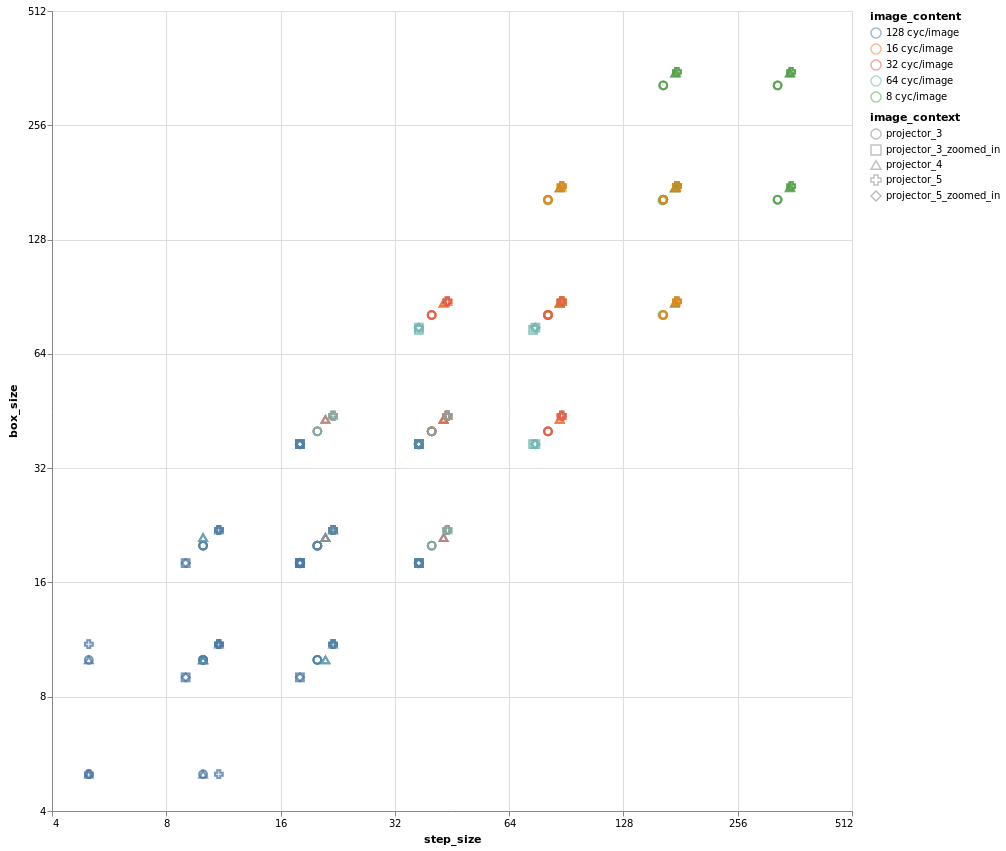

In [4]:
alt_df = df[[c for c in df.columns if c not in ['means', 'stddevs', 'actual_stddevs']]]
alt.Chart(alt_df).mark_point(size=60, opacity=.5,).encode(
    x=alt.X('step_size', scale=alt.Scale(base=2, type='log')), y=alt.Y('box_size', scale=alt.Scale(base=2, type='log')),
    color='image_content:N', shape='image_context:N',
    tooltip=['image_content', 'image_context','cycle_size_pix', 'step_size', 'box_size', 'box_size_multiple', 'step_size_multiple', ]
).properties(height=800, width=800).interactive()

In [6]:
tmp = df[(df.preprocess_type=='dcraw_vng_demosaic')&(df.box_size_multiple==2)&(df.step_size_multiple==2)]


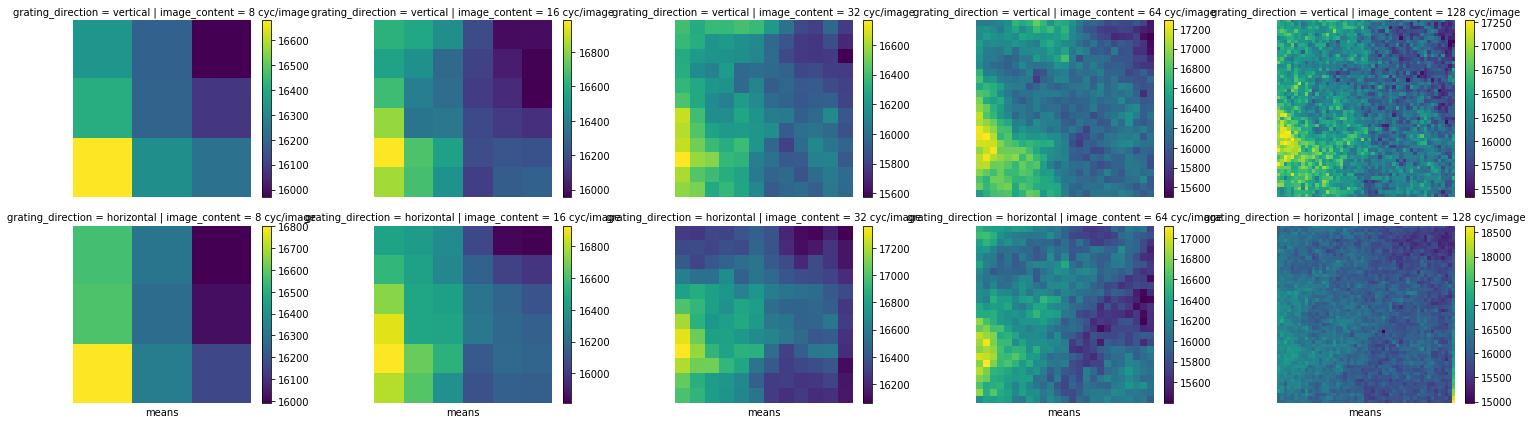

In [7]:
g = sns.FacetGrid(tmp[tmp.image_context=='projector_3'], 'grating_direction', 'image_content', sharex=False, sharey=False, aspect=1.4, margin_titles=False)
g.map(dfa.ArrayData_imshow, 'means', cmap=None, colorbar=True)

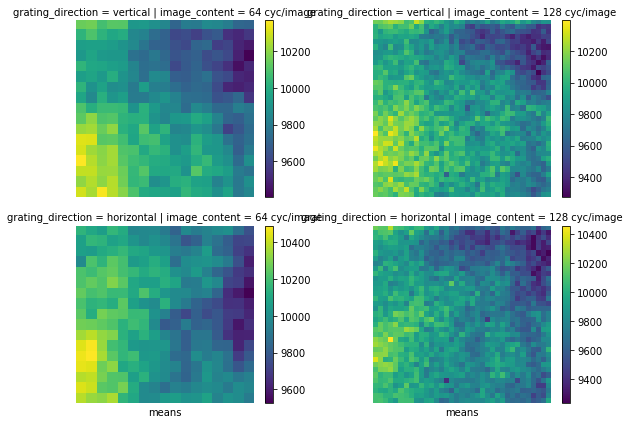

In [8]:
g = sns.FacetGrid(tmp[tmp.image_context=='projector_3_zoomed_in'], 'grating_direction', 'image_content', sharex=False, sharey=False, aspect=1.4, margin_titles=False)
g.map(dfa.ArrayData_imshow, 'means', cmap=None, colorbar=True)

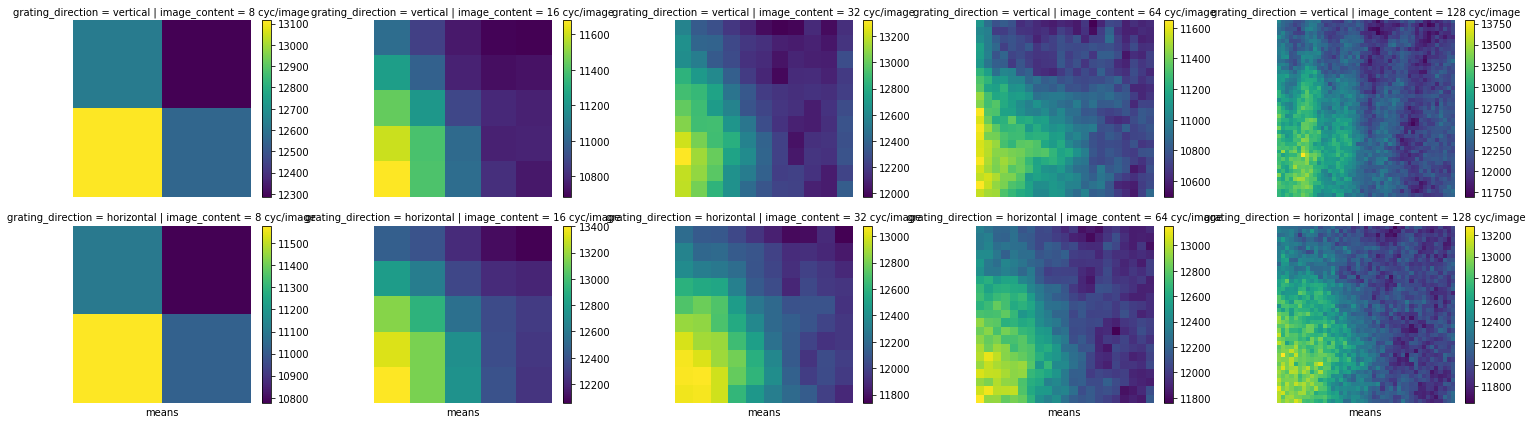

In [9]:
g = sns.FacetGrid(tmp[tmp.image_context=='projector_4'], 'grating_direction', 'image_content', sharex=False, sharey=False, aspect=1.4, margin_titles=False)
g.map(dfa.ArrayData_imshow, 'means', cmap=None, colorbar=True)

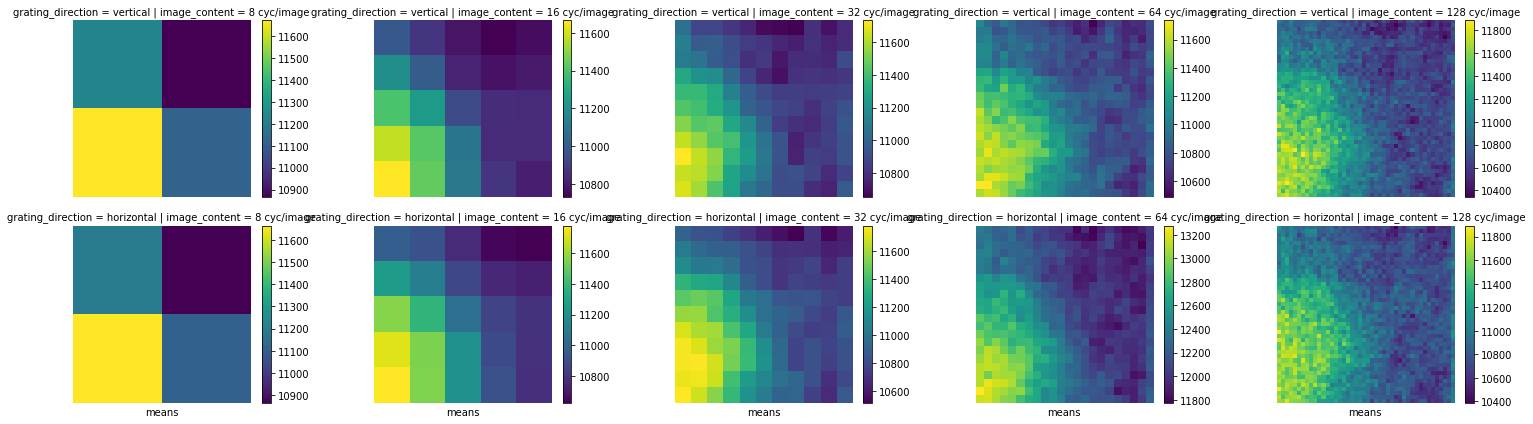

In [10]:
g = sns.FacetGrid(tmp[tmp.image_context=='projector_5'], 'grating_direction', 'image_content', sharex=False, sharey=False, aspect=1.4, margin_titles=False)
g.map(dfa.ArrayData_imshow, 'means', cmap=None, colorbar=True)

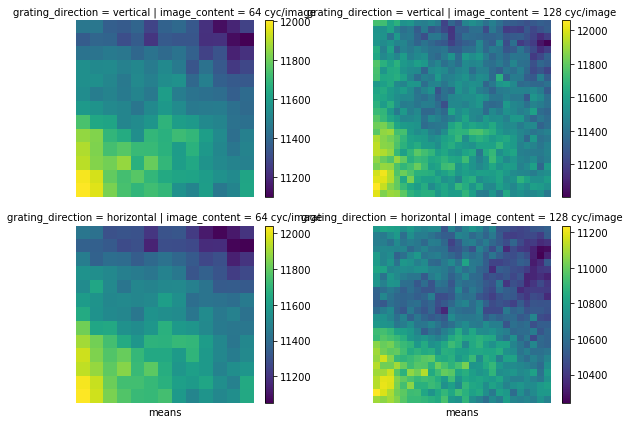

In [11]:
g = sns.FacetGrid(tmp[tmp.image_context=='projector_5_zoomed_in'], 'grating_direction', 'image_content', sharex=False, sharey=False, aspect=1.4, margin_titles=False)
g.map(dfa.ArrayData_imshow, 'means', cmap=None, colorbar=True)

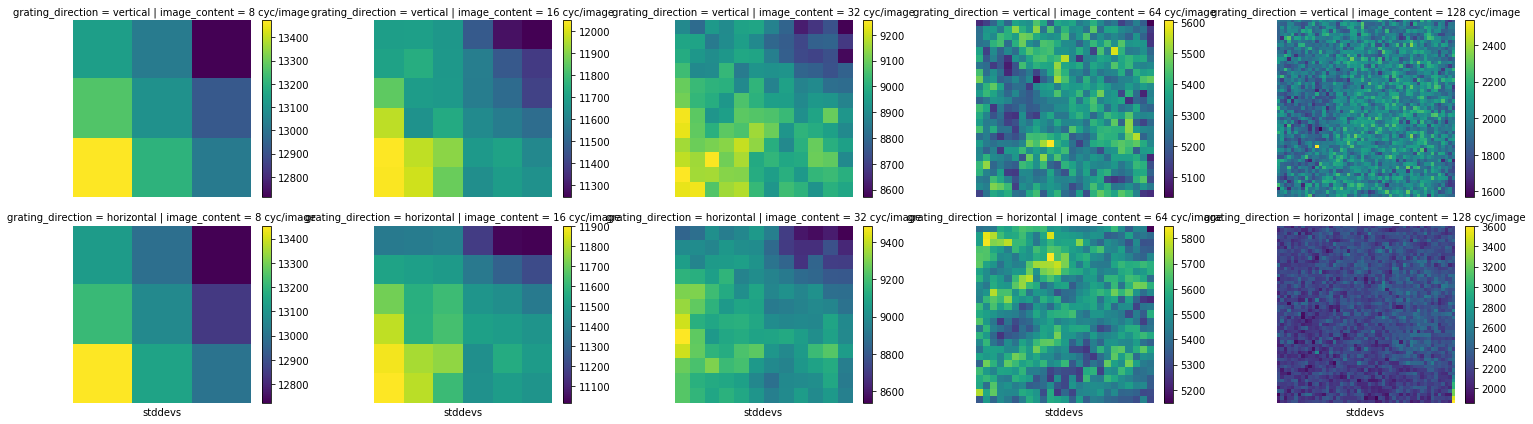

In [12]:
g = sns.FacetGrid(tmp[tmp.image_context=='projector_3'], 'grating_direction', 'image_content', sharex=False, sharey=False, aspect=1.4, margin_titles=False)
g.map(dfa.ArrayData_imshow, 'stddevs', cmap=None, colorbar=True)

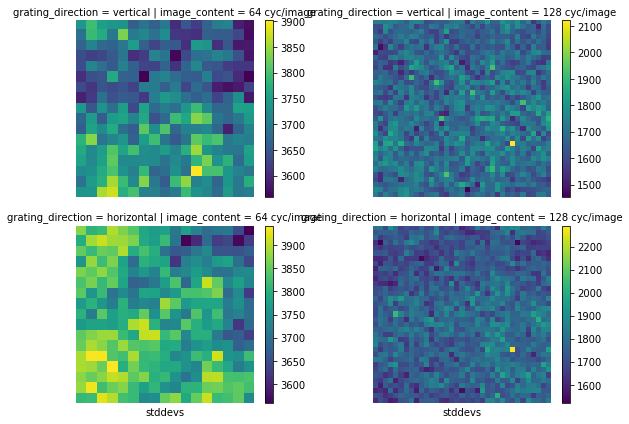

In [13]:
g = sns.FacetGrid(tmp[tmp.image_context=='projector_3_zoomed_in'], 'grating_direction', 'image_content', sharex=False, sharey=False, aspect=1.4, margin_titles=False)
g.map(dfa.ArrayData_imshow, 'stddevs', cmap=None, colorbar=True)

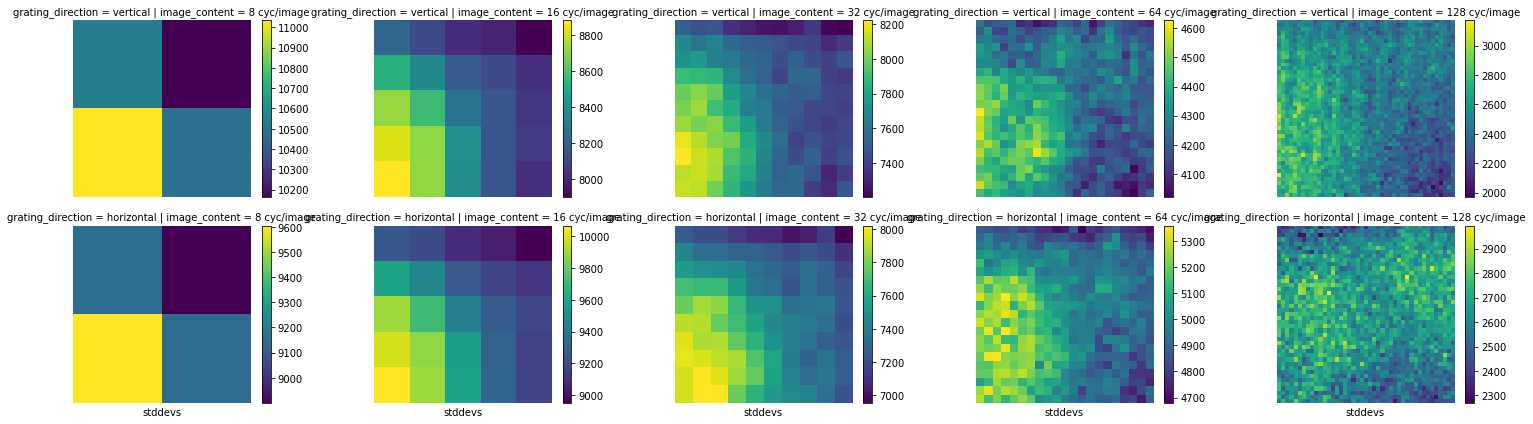

In [14]:
g = sns.FacetGrid(tmp[tmp.image_context=='projector_4'], 'grating_direction', 'image_content', sharex=False, sharey=False, aspect=1.4, margin_titles=False)
g.map(dfa.ArrayData_imshow, 'stddevs', cmap=None, colorbar=True)

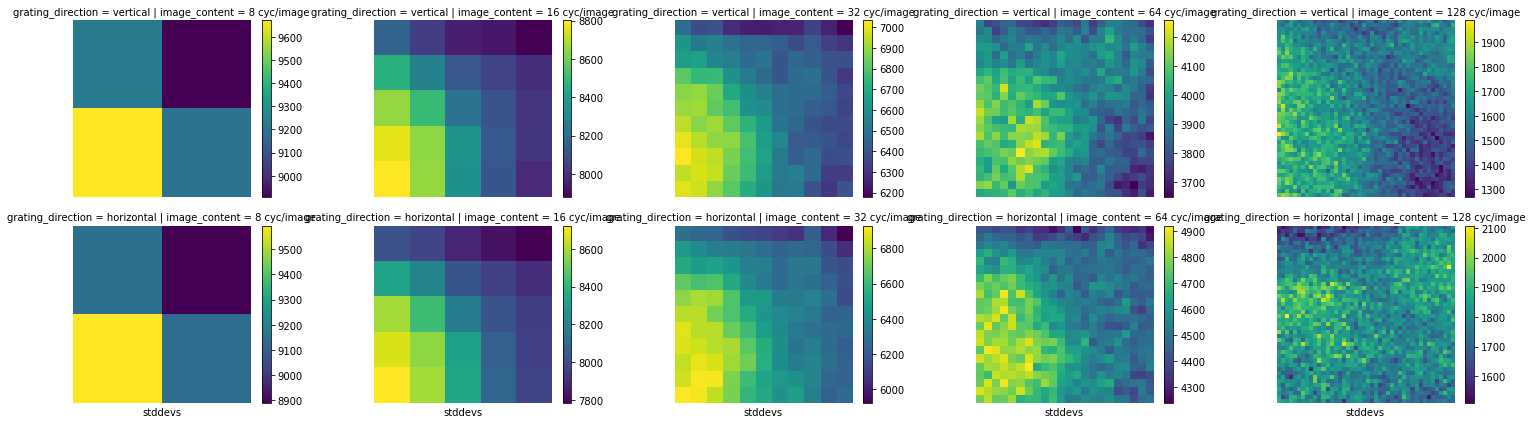

In [15]:
g = sns.FacetGrid(tmp[tmp.image_context=='projector_5'], 'grating_direction', 'image_content', sharex=False, sharey=False, aspect=1.4, margin_titles=False)
g.map(dfa.ArrayData_imshow, 'stddevs', cmap=None, colorbar=True)

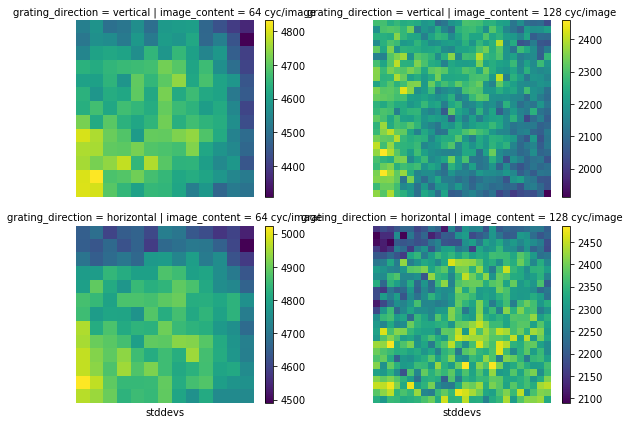

In [16]:
g = sns.FacetGrid(tmp[tmp.image_context=='projector_5_zoomed_in'], 'grating_direction', 'image_content', sharex=False, sharey=False, aspect=1.4, margin_titles=False)
g.map(dfa.ArrayData_imshow, 'stddevs', cmap=None, colorbar=True)